In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import nltk
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    log_loss,
    hamming_loss,
    matthews_corrcoef,
    zero_one_loss,
    jaccard_score,
    multilabel_confusion_matrix
)

nltk.download('vader_lexicon')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df=pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")

In [4]:
mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

In [5]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)

In [7]:
df.shape

(53043, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [9]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [10]:
mode=df["statement"].mode()[0]
df["statement"]=df["statement"].fillna(mode)

In [11]:
df.isnull().sum()

statement    0
status       0
dtype: int64

In [12]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [13]:
df["status"].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

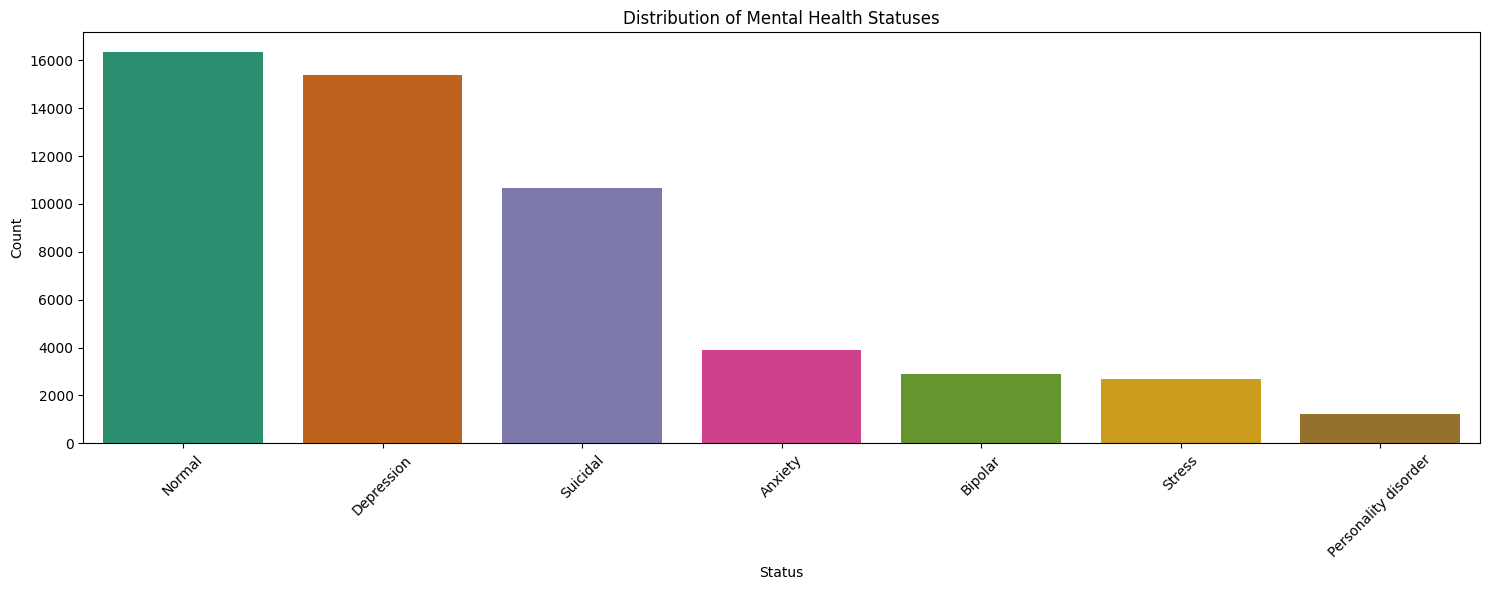

In [14]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='Dark2')

plt.title('Distribution of Mental Health Statuses')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

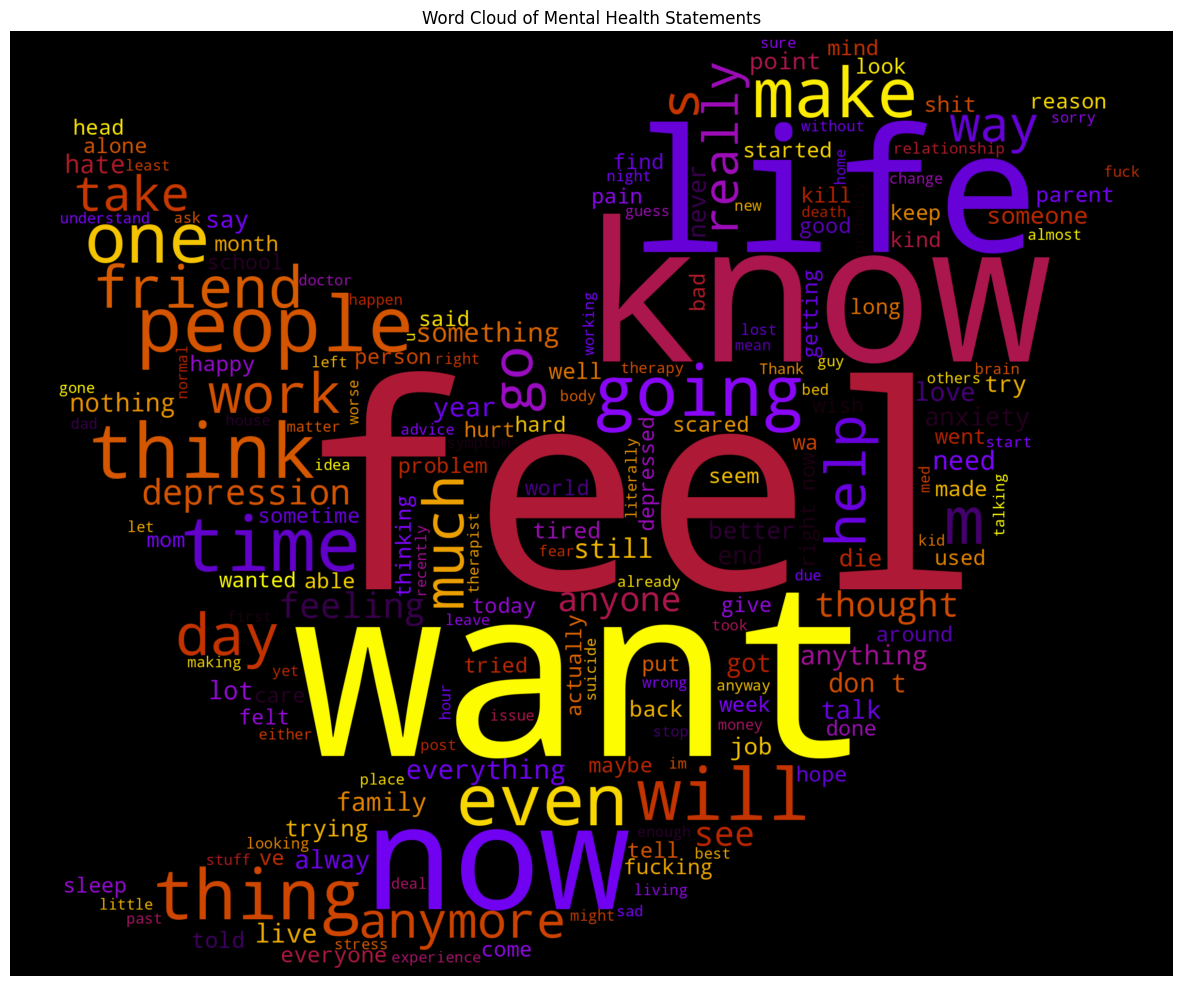

In [15]:
text = ' '.join(df['statement'])
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=800, height=600, background_color='black', min_font_size=10, 
                      stopwords=stopwords,mask=mask,colormap="gnuplot").generate(text)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Mental Health Statements')
plt.show()

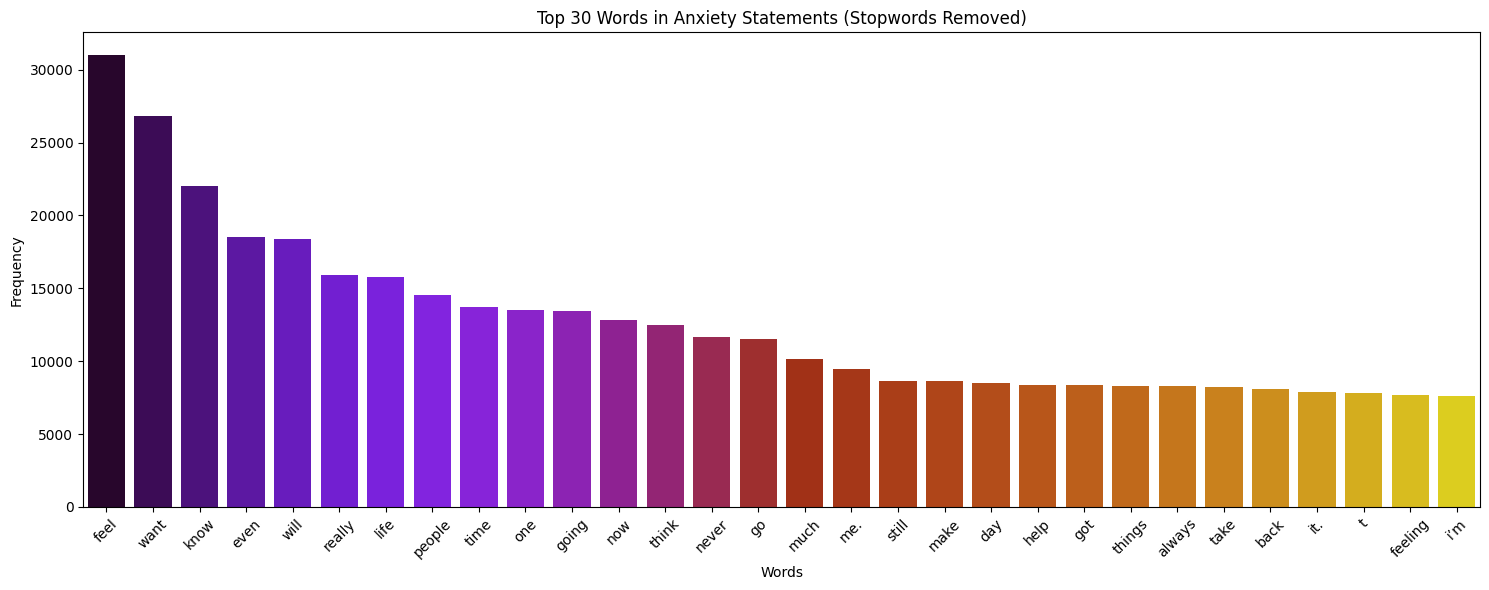

In [16]:
stopwords = set(STOPWORDS)
words = ' '.join(df['statement']).split()
filtered_words = [word.lower() for word in words if word.lower() not in stopwords]

word_counts = Counter(filtered_words)
top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:30])

top_words_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])
plt.figure(figsize=(15, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency', palette='gnuplot')
plt.title('Top 30 Words in Anxiety Statements (Stopwords Removed)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

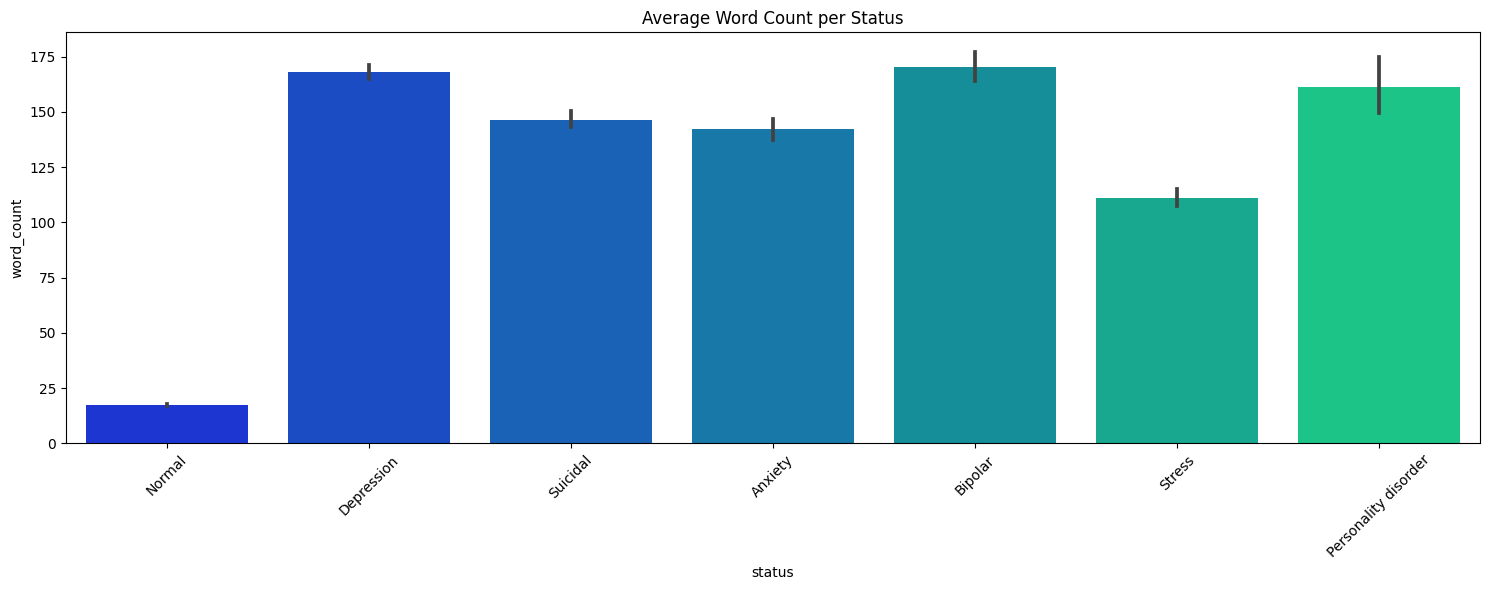

In [17]:
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15, 6))
sns.barplot(x='status', y='word_count', data=df, estimator=np.mean, order=df['status'].value_counts().index,palette="winter")
plt.title('Average Word Count per Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


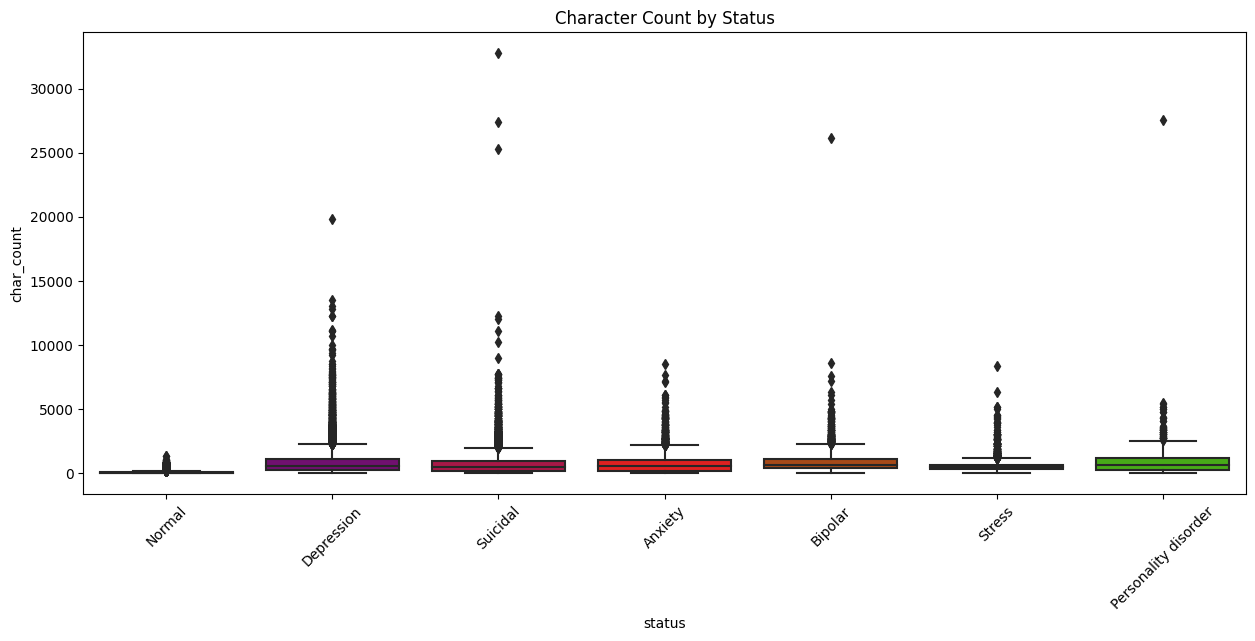

In [18]:
df['char_count'] = df['statement'].apply(len)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='status', y='char_count', order=df['status'].value_counts().index, palette='brg')
plt.title('Character Count by Status')
plt.xticks(rotation=45)
plt.show()

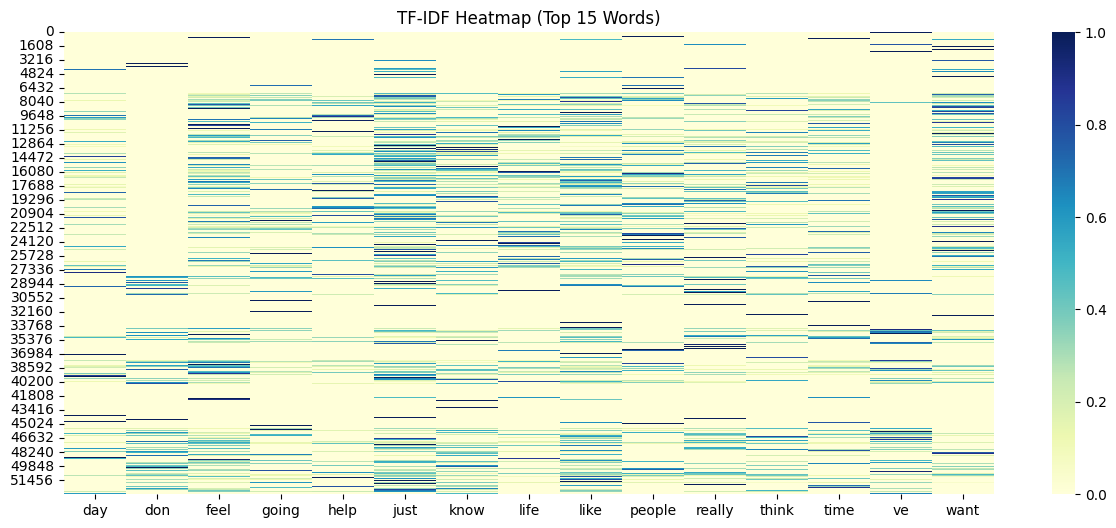

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=15, stop_words='english')
X = tfidf.fit_transform(df['statement'])
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

plt.figure(figsize=(15, 6))
sns.heatmap(tfidf_df, cmap='YlGnBu')
plt.title('TF-IDF Heatmap (Top 15 Words)')
plt.show()

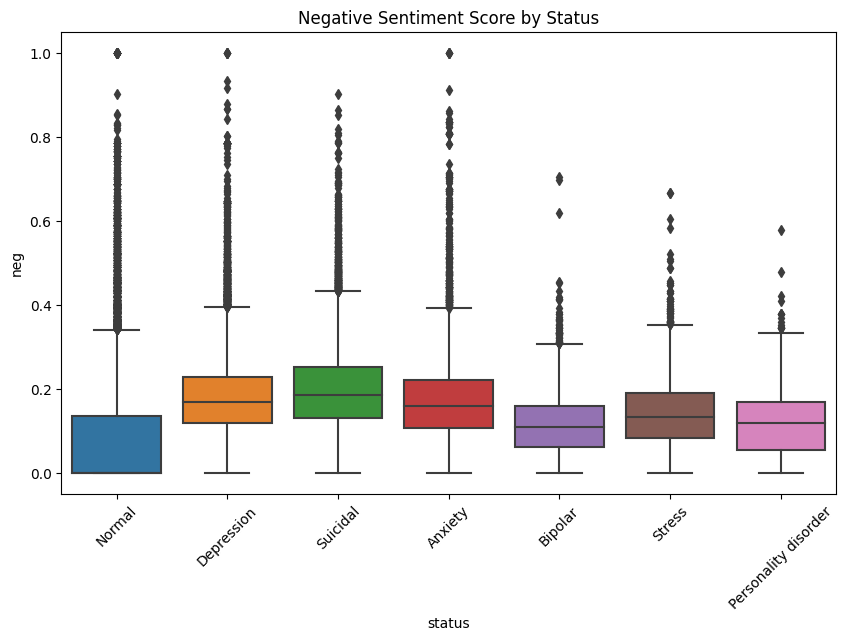

In [20]:
sid = SentimentIntensityAnalyzer()

df['neg'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = df['statement'].apply(lambda x: sid.polarity_scores(x)['neu'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='status', y='neg', order=df['status'].value_counts().index)
plt.title('Negative Sentiment Score by Status')
plt.xticks(rotation=45)
plt.show()

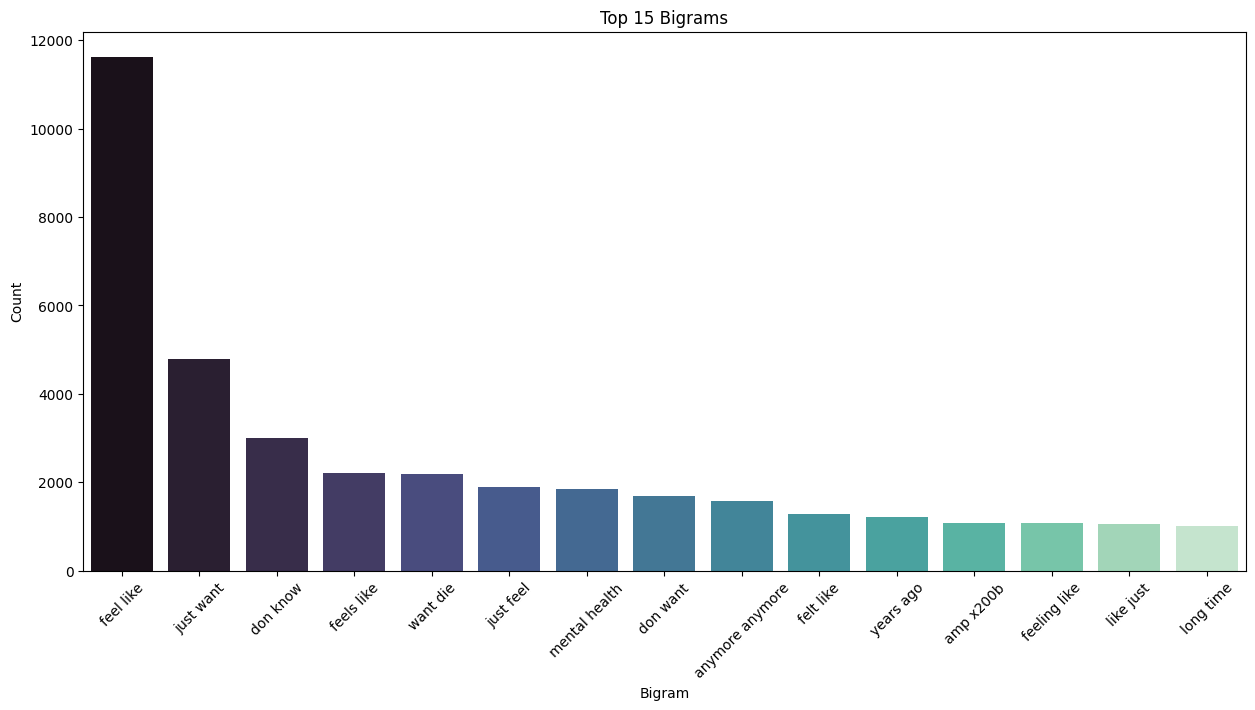

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vec.fit_transform(df['statement'])
sum_bigrams = bigrams.sum(axis=0)
bigram_freq = [(word, sum_bigrams[0, idx]) for word, idx in vec.vocabulary_.items()]
top_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:15]

bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
plt.figure(figsize=(15,7))
sns.barplot(data=bigram_df, x='Bigram', y='Count', palette='mako')
plt.xticks(rotation=45)
plt.title('Top 15 Bigrams')
plt.show()

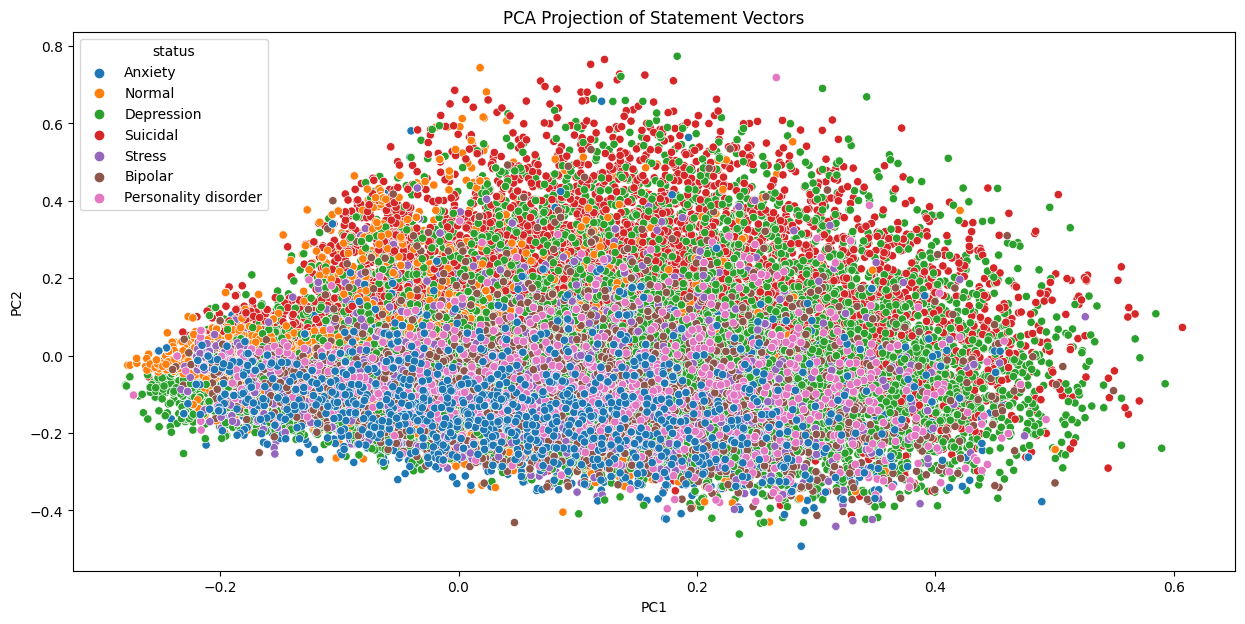

In [22]:
from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X = tfidf.fit_transform(df['statement'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['status'] = df['status'].values

plt.figure(figsize=(15, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='status', palette='tab10')
plt.title('PCA Projection of Statement Vectors')
plt.show()


In [23]:
df.head()

,statement,status,word_count,char_count,neg,pos,neu
0,oh my gosh,Anxiety,3,10,0.000,0.000,1.000
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,0.504,0.000,0.496
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,0.480,0.127,0.392
3,I've shifted my focus to something else but I'...,Anxiety,11,61,0.219,0.000,0.781
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,0.276,0.000,0.724


In [24]:
from transformers import AutoTokenizer, RobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base",num_labels=7)
model.to(device)

2025-06-30 08:00:43.409673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751270443.598283     104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751270443.649307     104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [25]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
le=LabelEncoder()
df["label"]=le.fit_transform(df["status"])
print(dict(zip(le.classes_,range(len(le.classes_)))))

{'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [26]:
def tokenize_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=128)
dataset = Dataset.from_pandas(df[["statement", "label"]])
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/53043 [00:00<?, ? examples/s]

In [27]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
train_dataset = Dataset.from_pandas(train_df[["statement", "label"]]).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[["statement", "label"]]).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df[["statement", "label"]]).map(tokenize_function, batched=True)

Map:   0%|          | 0/42434 [00:00<?, ? examples/s]

Map:   0%|          | 0/5304 [00:00<?, ? examples/s]

Map:   0%|          | 0/5305 [00:00<?, ? examples/s]

In [28]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from tabulate import tabulate
import time

optimizer = AdamW(model.parameters(), lr=0.00002)
num_epochs = 10
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)


loss_fn = nn.CrossEntropyLoss().to(device)



In [31]:
metrics_table = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float("inf")
patience = 5
patience_counter = 0

# Start total runtime measurement
total_start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Training Loop
    train_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        train_correct += torch.sum(preds == labels).item()
        train_total += labels.size(0)
    
    train_end_time = time.time()
    train_time = train_end_time - train_start_time
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation Loop
    val_start_time = time.time()
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_end_time = time.time()
    val_time = val_end_time - val_start_time
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    # Calculate total epoch time
    epoch_time = train_time + val_time
    
    # Store metrics with times for tabulate
    metrics_table.append([
        epoch + 1,
        f"{avg_train_loss:.4f}",
        f"{train_accuracy:.4f}",
        f"{avg_val_loss:.4f}",
        f"{val_accuracy:.4f}",
        f"{val_f1:.4f}",
        f"{train_time:.2f}s",
        f"{val_time:.2f}s",
        f"{epoch_time:.2f}s"
    ])
    
    # Print metrics using tabulate
    headers = ["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy", "Val F1", "Train Time", "Val Time", "Epoch Time"]
    print("\nMetrics:")
    print(tabulate(metrics_table, headers=headers, tablefmt="grid"))
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_pretrained("/kaggle/working/best_roberta_emotion")
        tokenizer.save_pretrained("/kaggle/working/best_roberta_emotion")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Calculate and print total runtime
total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_time // 60:.0f}m {total_time % 60:.2f}s")


Epoch 1/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.30it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+

Epoch 2/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.29it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+

Epoch 3/10


Validation: 100%|██████████| 166/166 [00:17<00:00,  9.30it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3089 |           0.8707 |     0.4441 |         0.8277 |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.30it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3089 |           0.8707 |     0.4441 |         0.8277 |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.31it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3089 |           0.8707 |     0.4441 |         0.8277 |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.31it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3089 |           0.8707 |     0.4441 |         0.8277 |   0.

Validation: 100%|██████████| 166/166 [00:17<00:00,  9.27it/s]



Metrics:
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|   Epoch |   Train Loss |   Train Accuracy |   Val Loss |   Val Accuracy |   Val F1 | Train Time   | Val Time   | Epoch Time   |
+=========+==============+==================+============+================+==========+==============+============+==============+
|       1 |       0.5803 |           0.7721 |     0.4688 |         0.8086 |   0.8114 | 523.03s      | 17.84s     | 540.87s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       2 |       0.3842 |           0.8402 |     0.418  |         0.8299 |   0.8309 | 523.17s      | 17.87s     | 541.04s      |
+---------+--------------+------------------+------------+----------------+----------+--------------+------------+--------------+
|       3 |       0.3089 |           0.8707 |     0.4441 |         0.8277 |   0.

In [43]:
import os
save_path = "/kaggle/working/save_roberta_model"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)


In [44]:
ls /kaggle/working/save_roberta_model

config.json  model.safetensors        tokenizer_config.json  vocab.json
merges.txt   special_tokens_map.json  tokenizer.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


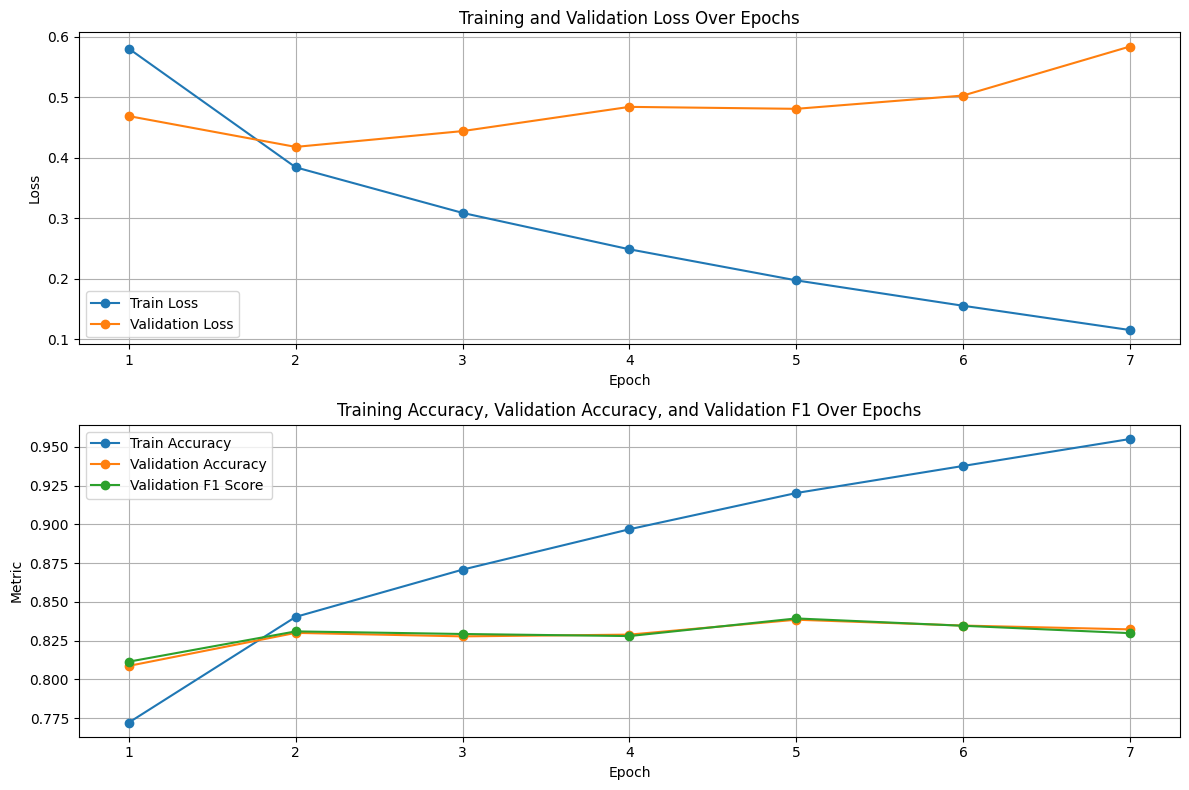

In [33]:
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy and F1
plt.subplot(2, 1, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label="Validation F1 Score", marker="o")
plt.title("Training Accuracy, Validation Accuracy, and Validation F1 Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
label_name=['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']

In [35]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        test_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        test_correct += torch.sum(preds == labels).item()
        test_total += labels.size(0)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate average loss and metrics
avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = test_correct / test_total
test_f1 = f1_score(test_labels, test_preds, average="weighted")

# Print summary table
print("\nTest Metrics:")
print(tabulate([[avg_test_loss, test_accuracy, test_f1]],
               headers=["Test Loss", "Test Accuracy", "Test F1"],
               tablefmt="grid"))

# Print full classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, digits=4,target_names=label_name))


Testing: 100%|██████████| 166/166 [00:17<00:00,  9.28it/s]



Test Metrics:
+-------------+-----------------+-----------+
|   Test Loss |   Test Accuracy |   Test F1 |
+=============+=================+===========+
|    0.550442 |        0.839585 |  0.837672 |
+-------------+-----------------+-----------+

Detailed Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.8906    0.9211    0.9056       380
             Bipolar     0.8985    0.8536    0.8755       280
          Depression     0.7727    0.8387    0.8044      1581
              Normal     0.9592    0.9627    0.9609      1635
Personality disorder     0.6742    0.7295    0.7008       122
              Stress     0.7670    0.8201    0.7926       289
            Suicidal     0.7535    0.6277    0.6849      1018

            accuracy                         0.8396      5305
           macro avg     0.8165    0.8219    0.8178      5305
        weighted avg     0.8390    0.8396    0.8377      5305



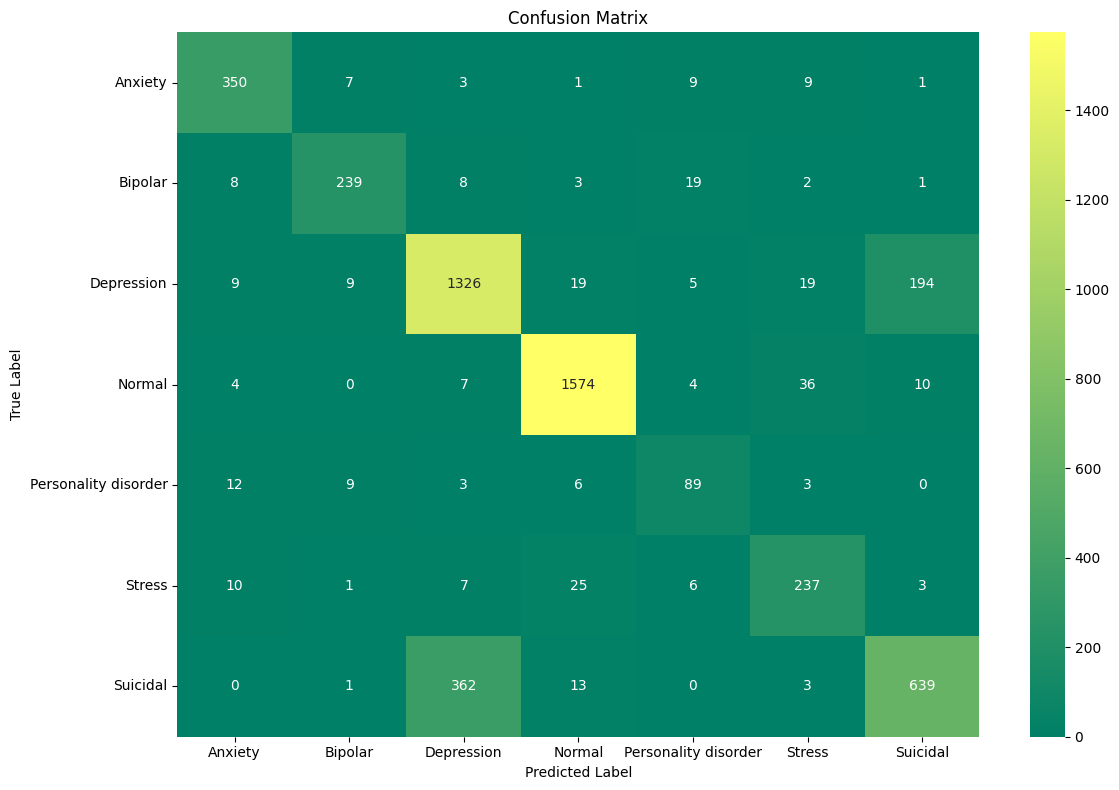

In [36]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="summer", xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Testing: 100%|██████████| 166/166 [00:17<00:00,  9.36it/s]


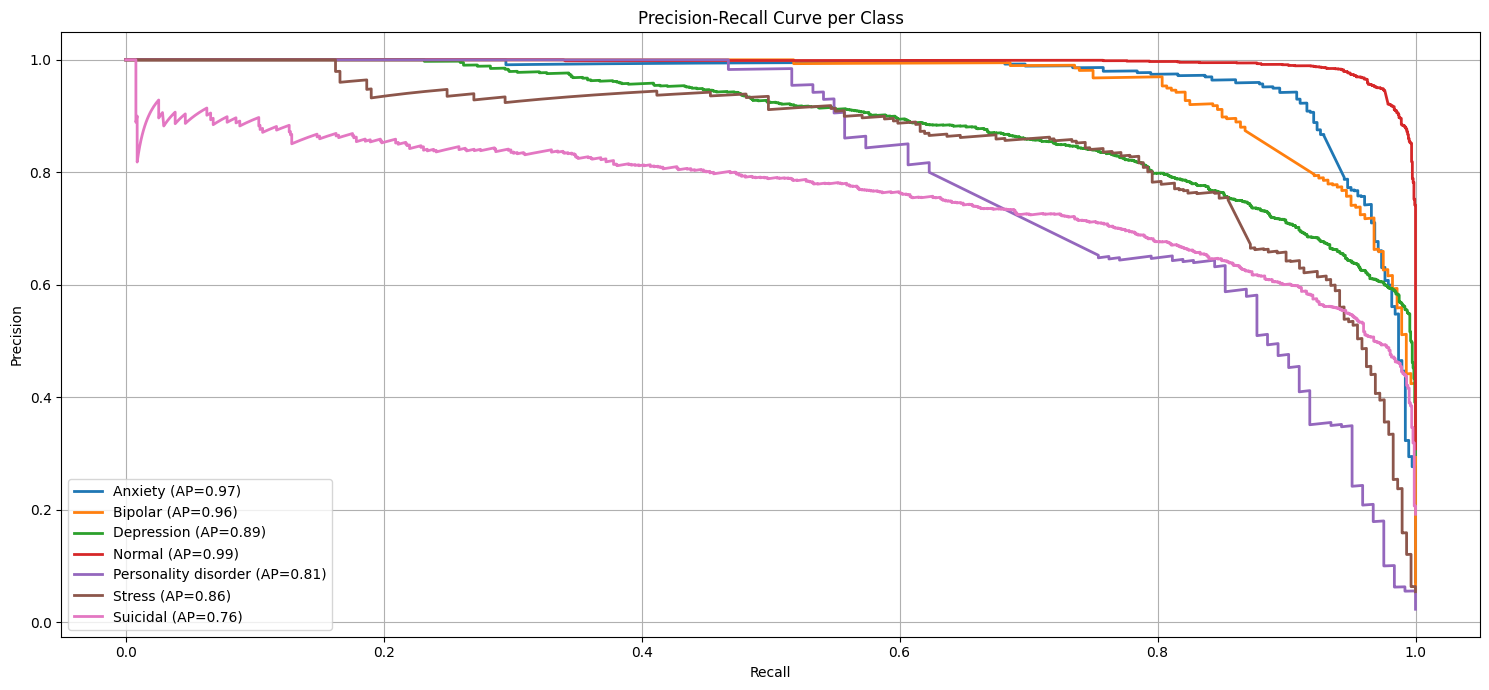

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

import torch.nn.functional as F

test_probs = []
test_preds = []
test_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)  # <-- probabilities per class

        _, preds = torch.max(logits, dim=1)
        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


num_classes = len(label_name)
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)  # predicted probabilities

# Plot Precision-Recall curve for each class
plt.figure(figsize=(15, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    avg_prec = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label_name[i]} (AP={avg_prec:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

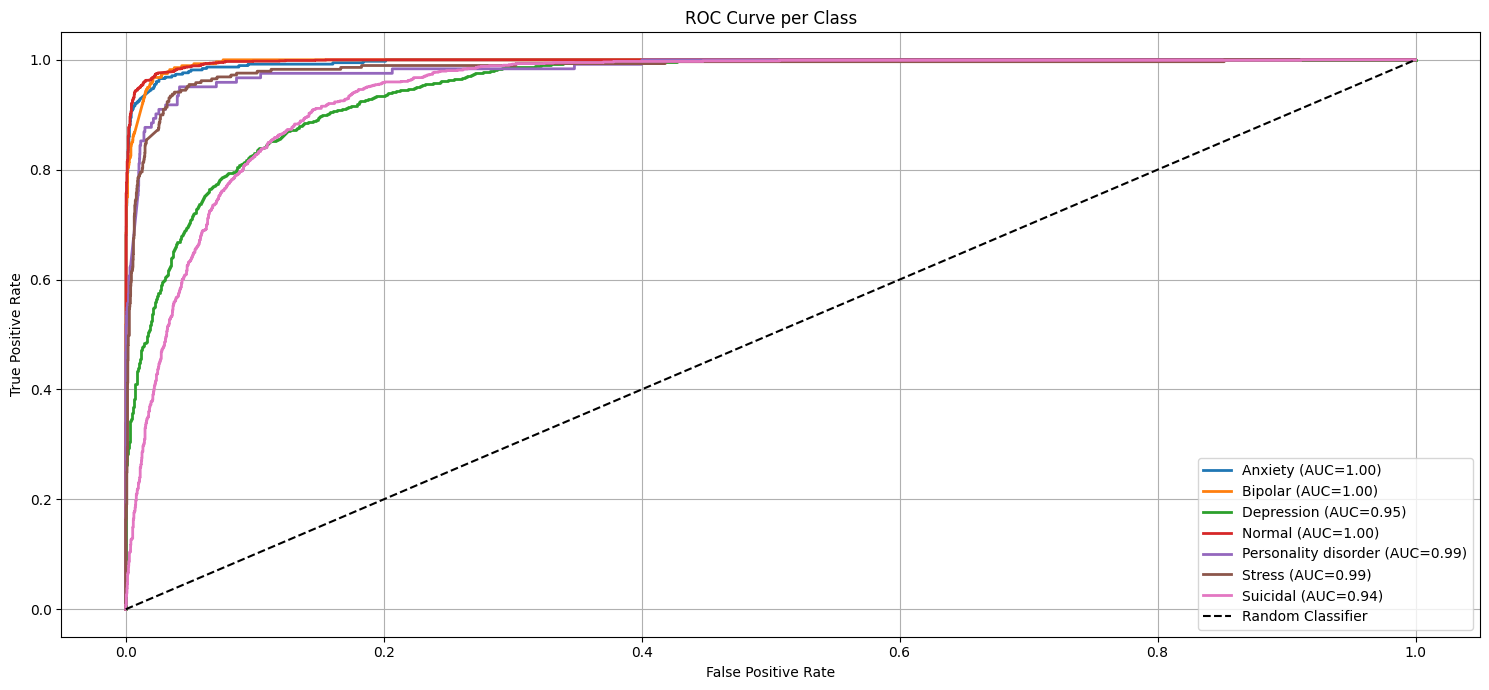

In [38]:
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)

plt.figure(figsize=(15, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{label_name[i]} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, cohen_kappa_score, log_loss
)

num_classes = len(np.unique(test_labels))
y_true_bin = label_binarize(test_labels, classes=list(range(num_classes)))
y_score = np.array(test_probs)

print("=== Classification Metrics ===")
print(f"Accuracy         : {accuracy_score(test_labels, test_preds):.4f}")
print(f"F1 Score (Macro) : {f1_score(test_labels, test_preds, average='macro'):.4f}")
print(f"Recall (Macro)   : {recall_score(test_labels, test_preds, average='macro'):.4f}")
print(f"Precision (Macro): {precision_score(test_labels, test_preds, average='macro'):.4f}")
print(f"ROC AUC Score    : {roc_auc_score(y_true_bin, y_score, average='macro'):.4f}")
print(f"Cohen Kappa Score: {cohen_kappa_score(test_labels, test_preds):.4f}")
print(f"Log Loss         : {log_loss(y_true_bin, y_score):.4f}")

=== Classification Metrics ===
Accuracy         : 0.8396
F1 Score (Macro) : 0.8178
Recall (Macro)   : 0.8219
Precision (Macro): 0.8165
ROC AUC Score    : 0.9793
Cohen Kappa Score: 0.7906
Log Loss         : 0.5509


In [40]:
def predict_batch_statements(texts, model, tokenizer, device):
    model.eval()
 
    inputs = tokenizer(texts,padding="max_length",truncation=True,max_length=128,return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_idxs = torch.argmax(probs, dim=1).cpu().numpy()
        confidences = probs.max(dim=1).values.cpu().numpy()

    results = []
    for idx, conf in zip(pred_idxs, confidences):
        results.append((label_name[idx], conf))
    return results


model.to(device)

texts = [
    "I feel constant worry and nervousness all day.",               # Anxiety
    "My moods change dramatically and unpredictably.",               # Bipolar
    "I’ve been feeling very sad and hopeless lately.",               # Depression
    "I’m doing well and feel balanced emotionally.",                 # Normal
    "I often find it hard to relate to others and myself.",          # Personality disorder
    "Work pressure and daily life stress are overwhelming me.",      # Stress
    "Sometimes I think life isn’t worth living anymore.",             # Suicidal
]

predictions = predict_batch_statements(texts, model, tokenizer, device)
for text, (label, conf) in zip(texts, predictions):
    print(f"Text: {text}\nPredicted: {label} (confidence: {conf:.4f})\n")


Text: I feel constant worry and nervousness all day.
Predicted: Anxiety (confidence: 0.9985)

Text: My moods change dramatically and unpredictably.
Predicted: Normal (confidence: 0.9996)

Text: I’ve been feeling very sad and hopeless lately.
Predicted: Anxiety (confidence: 0.7969)

Text: I’m doing well and feel balanced emotionally.
Predicted: Normal (confidence: 0.9808)

Text: I often find it hard to relate to others and myself.
Predicted: Normal (confidence: 0.8694)

Text: Work pressure and daily life stress are overwhelming me.
Predicted: Stress (confidence: 0.9783)

Text: Sometimes I think life isn’t worth living anymore.
Predicted: Depression (confidence: 0.7934)



In [41]:
import shutil

shutil.make_archive('/kaggle/working/best_roberta_emotion_zip', 'zip', '/kaggle/working/best_roberta_emotion')


'/kaggle/working/best_roberta_emotion_zip.zip'

In [42]:
! pip freeze

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper